Logistic Regression: Mean Accuracy = 0.811
Random Forest: Mean Accuracy = 0.813
SVM: Mean Accuracy = 0.836
Confusion Matrix:
 [[67 15]
 [10 92]]
              precision    recall  f1-score   support

           0      0.870     0.817     0.843        82
           1      0.860     0.902     0.880       102

    accuracy                          0.864       184
   macro avg      0.865     0.860     0.862       184
weighted avg      0.864     0.864     0.864       184



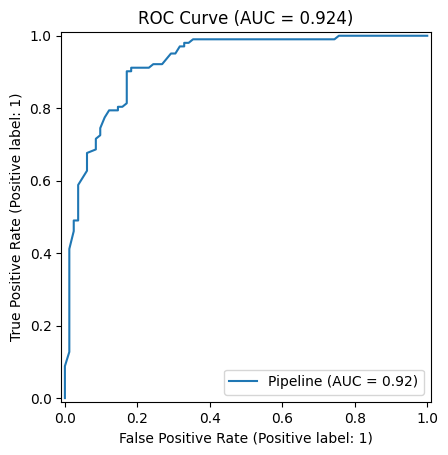

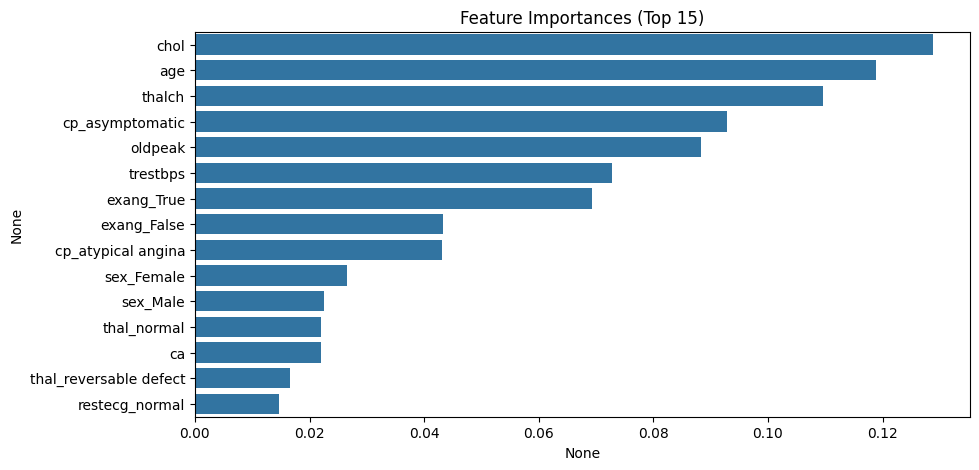

In [2]:
# ===================== 1. LIBRARIES & SETUP =====================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# ================= 2. LOAD & SPLIT DATA =========================
df = pd.read_csv('heart_disease_uci.csv')
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)  # Binary target

X = df.drop(['target', 'num', 'id', 'dataset'], axis=1, errors='ignore')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ============ 3. PIPELINE SETUP & PREPROCESSING =================
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# ======================= 4. MODELING ============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('pre', preprocessor),
        ('cls', model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = scores
    print(f"{name}: Mean Accuracy = {scores.mean():.3f}")

# =============== 5. BEST MODEL FULL FIT & EVALUATION =============
# اختر أفضل Model بناءً على النتائج السابقة (هنا مثلا Random Forest)
best_model = RandomForestClassifier()
full_pipe = Pipeline([
    ('pre', preprocessor),
    ('cls', best_model)
])
full_pipe.fit(X_train, y_train)
y_pred = full_pipe.predict(X_test)
y_prob = full_pipe.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

# ROC Curve
roc_auc = roc_auc_score(y_test, y_prob)
disp = RocCurveDisplay.from_estimator(full_pipe, X_test, y_test)
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()

# =============== 6. (OPTIONAL) FEATURE IMPORTANCE ================
importances = full_pipe.named_steps['cls'].feature_importances_
feature_names = (
    list(numeric_features)
    + list(full_pipe.named_steps["pre"].transformers_[1][1]
        .named_steps["encoder"].get_feature_names_out(categorical_features))
)
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title("Feature Importances (Top 15)")
plt.show()
